In [302]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Считаем наши данные:

In [303]:
data = pd.read_csv("forestfires.csv")

Добавим в них константный признак и посмотрим на несколько первых строчек:

In [304]:
data.insert(0, "const", 1)
data.head()

,const,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,1,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,1,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,1,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Заменим координату month на индикатор летнего сезона, а координату day убереме и не будем использовать:

In [305]:
data['month'] = data['month'].apply(lambda x: int(x in ["jun", "jul", "aug"]))
data = data.drop("day", 1)
data.head()

,const,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,1,7,4,0,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,1,7,4,0,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,1,8,6,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,1,8,6,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Для удобства сформируем из наших данных двумерный numpy-массив:

In [306]:
values = np.array(data.values, dtype=float)

Перемешаем нашу выборку:

In [307]:
random.shuffle(values)

Разделим нашу выборку в соотношении 7:3. train_labels и test_labels - значения координаты area, которую мы и будем предсказывать.

In [308]:
train_data = values[:int(len(values) * 0.7)][:, 0:-1]
train_labels = values[:int(len(values) * 0.7)][:, -1]
test_data = values[len(train_data):][:, 0:-1]
test_labels = values[len(train_data):][:, -1]

В линейной регрессионой моделе: $X = l + \epsilon = z\theta + \epsilon$, где $l \in L$, $z$ - базис в $L$, $\epsilon$ - случайный вектор. Наша задача оценить $\theta$. В явном виде оценка $\hat{\theta}$ методом наименьших квадратов выглядит как: 
$$\hat{\theta} = (z^T z)^{-1}z^TX.$$
Тогда среднеквадратичная ошибка равна:
$$\frac{\sum_{i=1}^n(X_i - (z\hat{\theta})_i)^2}{n}.$$
В нашем случае $X$ - координаты area, то есть test_labels, а $z$ - остальные координаты для тестовой выборки.

Заметим, что количество нулей в координате rain очень велико, поэтому может так случиться, что в тренировочную выборку попадут все строки, у которых в этой координате 0, тогда мы не сможем оценить параметр $\theta$, так как не сможем взять обратную от $z^T z$.

In [309]:
print("zeros = ", np.sum([values[i][-2] == 0 for i in range(len(values))]))
print("total = ", len(values))

zeros =  507
total =  517


Поэтому будем перемешивать наши данные, пока в тренировочную выборку не попадет хотя бы одна строка с ненулевой координатой rain.

In [310]:
while np.amax(train_data, axis=0)[-1] == 0:
    values = np.array(data.values, dtype=float)
    random.shuffle(values)
    train_data = values[:int(len(values) * 0.7)][:, 0:-1]
    train_labels = values[:int(len(values) * 0.7)][:, -1]
    test_data = values[len(train_data):][:, 0:-1]
    test_labels = values[len(train_data):][:, -1]

Теперь посчитаем $\hat{\theta}$ по тренировочной выборке:

In [311]:
coeffs = np.linalg.inv(train_data.T @ train_data) \
    @ np.transpose(train_data) @ train_labels

Найдем среднеквадратическую ошибку на тестовой выборке:

In [312]:
((test_labels - test_data @ coeffs) ** 2).mean()

15299.677762366402

Как мы видим, данная ошибка является достаточно большой, что говорит о не очень хорошем результате для данной выборки. Причем, при другом разбиении, ошибка будет сильно отличаться, но тоже будет большой.

Теперь сделаем для area преобразование $f(x) = ln(x+c)$ и построим для нее новую регрессионную модель. Посчитаем среднеквадратичную ошибку и по сетке $c \in [2, 100]$ найдем $c$, при котором ошибка наименьшая.

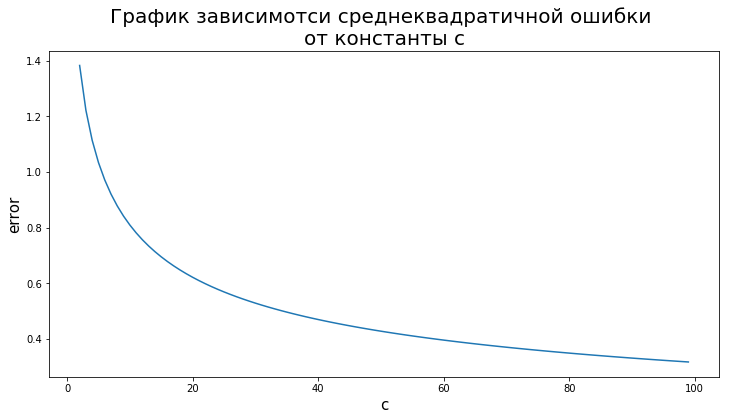

In [313]:
consts = np.arange(2, 100)
errors = []
for const in consts:
    new_train_labels = np.log(train_labels + const)
    new_test_labels = np.log(test_labels + const)

    coeffs = np.linalg.inv(np.transpose(train_data) @ train_data) \
        @ np.transpose(train_data) @ new_train_labels
    errors.append(np.sqrt(((new_test_labels \
                            - test_data @ coeffs) ** 2).mean()))

plt.figure(figsize=(12, 6))
plt.plot(consts, errors)
plt.ylabel("error", fontsize=15)
plt.xlabel("c", fontsize=15)
plt.title("""График зависимотси среднеквадратичной ошибки 
от константы c""", fontsize=20);

Как видно из графика, ошибка убыват при увеличении $c$, что и понятно, так как при больших $c$ влияние $x$ пренебрежимо мало и мы по сути оцениваем константу, которую регрессионая модель умеет очень хорошо приближать.

Тем не менее найдем $c$, при котором значение ошибки наименьшее и посмотрим сильно ли влияет разбиение на значение ошибки. Для этого посчитаем нашу оценку для 100 различных разбиений и построим гистограмму от значения среднеквадратичной ошибки. Аналогично предыдущему пункту будем перемешивать выборку, пока в тренировочную часть не попадет хотя бы одна строка с ненулевой rain координатой.

In [314]:
def CountError(data, const):
    current_data = data.copy()
    current_data["area"] = current_data["area"].apply(lambda x: np.log(x + const))
    
    
    while True:
        values = np.array(current_data.values, dtype=float)
        random.shuffle(values)

        train_data = values[:int(len(values) * 0.7)][:, 0:-1]
        train_labels = values[:int(len(values) * 0.7)][:, -1]
        test_data = values[len(train_data):][:, 0:-1]
        test_labels = values[len(train_data):][:, -1]
        
        if np.amax(train_data, axis=0)[-1] > 0:
            break

    coeffs = np.linalg.inv(np.transpose(train_data) @ train_data) \
        @ np.transpose(train_data) @ train_labels
    
    return np.sqrt(((test_labels - test_data @ coeffs) ** 2).mean())

c =  99


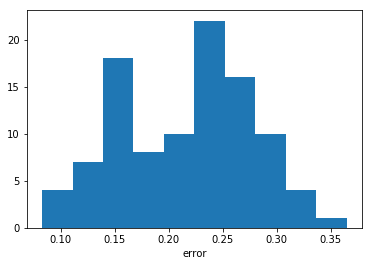

In [318]:
c = np.argmin(errors) + 2
print("c = ", c)
c_errors = []
for _ in range(100):
    c_errors.append((CountError(data, c)))
plt.hist(c_errors)
plt.xlabel("error");

Как мы видим, значение ошибки зависит от разбиения.

Вывод: мы построили линейную регрессионную модель для данной задачи и получили, что значение среднеквадратичной ошибки в данной моделе велико, поэтому данную модель не стоит использовать в данном случае. Также ошибка зависит от разбиения выборки даже тогда, когда влияние выборки мало (в случае большого значения c).